<a href="https://colab.research.google.com/github/thalitadru/ml-class-epf/blob/main/LabAssignment5_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Credits:* Exercises 1 through 5 are based on notebooks written by [A. Géron](https://colab.research.google.com/github/ageron/handson-ml2/) for his "Hands-on ML" book. Code realeased under [Apache 2.0 license](https://github.com/ageron/handson-ml2/blob/master/LICENSE).

In [2]:
import numpy as np 
import scipy as sp
import pandas as pd 
import matplotlib.pyplot as plt
import skimage.io
import seaborn as sns
import plotly.express as px

from IPython.display import display, HTML

import os
import urllib

## Exercise 1: Color quantization

In this exercise we'll user k-means to reduce the number of colors in an image. We'll work with the following example image:

In [3]:
# Download the ladybug image
images_path = "./images"
os.makedirs(images_path, exist_ok=True)
url = "https://github.com/ageron/handson-ml2/raw/master/images/unsupervised_learning/ladybug.png"
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/ladybug.png', <http.client.HTTPMessage at 0x7fb7602a7e80>)

In [4]:
image = skimage.io.imread(os.path.join(images_path, filename))
image.shape

(533, 800, 3)

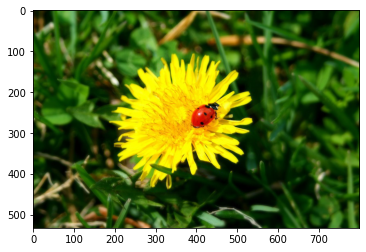

In [5]:
plt.imshow(image)

Our goal is to represent this same image using a reduced pallete of colors.
To do so, we want to find K colors that should summarize all the others. Try this procedure for K = {10,8,6,4,2} colors.
  1. Apply K-means to the image pixels. The centroids of each cluster will correspond to the color of that cluster
  2. Create a copy of the image mapping all its pixel values to that of their corresponding cluster centroid
  3. Display the new color-reduced images. Which pallete size looks best?

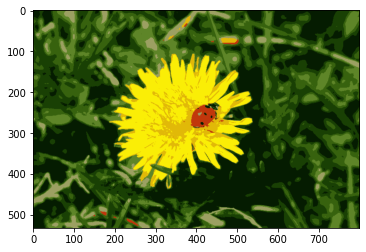

In [6]:
from sklearn.cluster import KMeans
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, init='k-means++', random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)
plt.imshow(segmented_img/255)

In [7]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

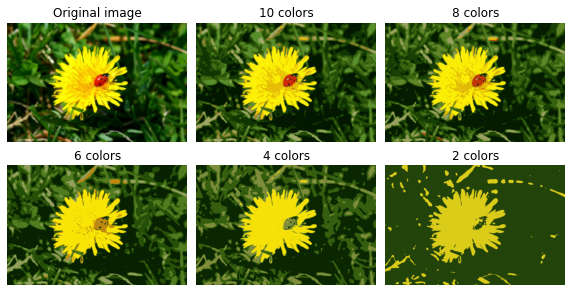

In [8]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx]/255)
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

## Exercise 2**: Clustering as a preprocessing step for classification

In this exercise, you are going to use clustering to improve the classification performance of logistic regression model on a digits dataset similar to MNIST.

In [9]:
from sklearn.datasets import load_digits

In [10]:
X_digits, y_digits = load_digits(return_X_y=True)

In [11]:
X_digits.shape, X_digits.shape

((1797, 64), (1797, 64))

(-0.5, 7.5, 7.5, -0.5)

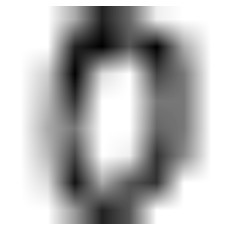

In [12]:
sample_id=0
size = np.ceil(np.sqrt(X_digits.shape[1])).astype(int)
plt.imshow(X_digits[sample_id].reshape([size, size]), cmap='binary', interpolation='bilinear')
plt.axis('off')

  1. Split this dataset into a training and a test set.
  2. Fit a logistic regression model and evaluate it on the test set. This should give you a baseline accuracy of about 96-97%
  3. Now we'll use clustering as a preprocessing step by including it in a `Pipeline`. Create a `Pipeline` (e.g. using `make_pipeline`) chaining K-means then Logistic Regression. Start trying out 50 clusters for K-means
  4. Evaluate you pipeline on the test set. Did you get a better score than before? By how much?
  5. We did choose the number of clusters in a completely arbitrary fashion. Use a hyperparameter search method (e.g. `GridSearchCV`) to test some other values for `n_clusters`.
  6. Compare your results before and after hyperparameters tuning. Could you improve the model?

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split in train/test
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [15]:
from sklearn.linear_model import LogisticRegression

In [16]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [17]:
log_reg_score = log_reg.score(X_test, y_test)
log_reg_score

0.9688888888888889

Okay, that's our baseline. Let's see if we can do better by using K-Means as a preprocessing step. We will create a pipeline that will first cluster the training set into 50 clusters and replace the images with their distances to the 50 clusters, then apply a logistic regression model:

In [18]:
from sklearn.pipeline import Pipeline

In [19]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [20]:
pipeline_score = pipeline.score(X_test, y_test)
pipeline_score

0.9777777777777777

Here is the improvement we got in accuracy:

In [21]:
(pipeline_score - log_reg_score).round(3)

0.009

This is a slight improvement but since we chose the number of clusters $k$ completely arbitrarily, we could likely do better by tweaking this hyperparameter.

Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for $k$ is much simpler than earlier: there's no need to perform silhouette analysis or minimize the inertia, the best value of $k$ is simply the one that results in the best classification performance.

In [22]:
from sklearn.model_selection import GridSearchCV

**Warning**: the following cell may take close to 20 minutes to run, or more depending on your hardware.

In [23]:
param_grid = dict(kmeans__n_clusters=np.arange(2, 100, 5))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, n_jobs=-1)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'kmeans__n_clusters': array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
       87, 92, 97])},
             verbose=2)

Let's see what the best number of clusters is:

In [24]:
grid_clf.best_params_

{'kmeans__n_clusters': 82}

In [25]:
grid_clf.score(X_test, y_test)

0.98

We can explore the grid search results to see how differently the different values of k performed:

In [26]:
cv_results = pd.DataFrame(grid_clf.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kmeans__n_clusters,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.268318,0.008602,0.001270,0.000080,2,{'kmeans__n_clusters': 2},0.436526,0.440980,0.387528,0.421678,0.024216,20
1,0.644224,0.034043,0.001367,0.000083,7,{'kmeans__n_clusters': 7},0.850780,0.839644,0.830735,0.840386,0.008200,19
2,1.894080,0.063007,0.001426,0.000043,12,{'kmeans__n_clusters': 12},0.930958,0.946548,0.917595,0.931700,0.011832,18
3,4.582954,0.400577,0.001420,0.000013,17,{'kmeans__n_clusters': 17},0.935412,0.953229,0.935412,0.941351,0.008399,17
4,5.037165,0.364540,0.001605,0.000104,22,{'kmeans__n_clusters': 22},0.939866,0.966592,0.951002,0.952487,0.010961,16
5,5.584551,0.176119,0.001626,0.000082,27,{'kmeans__n_clusters': 27},0.948775,0.966592,0.959911,0.958426,0.007349,13
6,6.210661,0.297377,0.001728,0.000167,32,{'kmeans__n_clusters': 32},0.944321,0.966592,0.962138,0.957684,0.009622,15
7,6.752589,0.586514,0.001881,0.000240,37,{'kmeans__n_clusters': 37},0.946548,0.968820,0.962138,0.959169,0.009332,12
8,7.453561,0.428956,0.001784,0.000061,42,{'kmeans__n_clusters': 42},0.951002,0.973274,0.957684,0.960653,0.009332,8
9,8.426744,0.543542,0.001878,0.000067,47,{'kmeans__n_clusters': 47},0.953229,0.966592,0.955457,0.958426,0.005846,14


(0.9, 1.0)

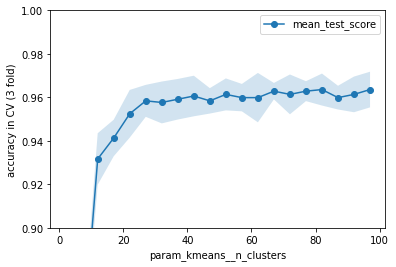

In [28]:
cv_results.param_kmeans__n_clusters = cv_results.param_kmeans__n_clusters.astype(int)
ax = cv_results.plot(x='param_kmeans__n_clusters', y='mean_test_score', marker='o')
ax.set_ylabel('accuracy in CV (3 fold)')
x = cv_results.param_kmeans__n_clusters
y = cv_results.mean_test_score
yerr = cv_results.std_test_score
ax.fill_between(x, y+yerr, y-yerr, alpha=0.2)
ax.set_ylim(0.9,1)

## Exercise 3**: Using clustering for semi-supervised learning

When we have little labeled samples but lots of unlabeled ones, clustering can help us profit from the information the unlabeled samples can gives us.
To demonstrate this idea, well re-use the previous digits dataset, but restrict ourselves to using only a handful of labels:


In [ ]:
n_labeled = 50
X_train_labeled, y_train_labeled = X_train[:n_labeled], y_train[:n_labeled]

### Use clustering to find representative samples
Now its up to you:
1. Train a logistic regression model on the reduced labeled training set. How lower is the accuracy compared to the previous experiment?
2. Now let's use all the samples to train a K-means clustering model. Start using 50 clusters. 
3. K-means will have found us 50 centroids that don't correspond directly to dataset images. We'll take the closest image to each centroid to represent that cluster. To do so, compute distances between images in the training set and the centroids found by k-means. *Tip*: You can use the method [`transform(X)`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html?highlight=kmeans#sklearn.cluster.KMeans.transform) from your trained k-means estimator to give you distances between all samples in `X` and the cluster centers.
4. Plot the 50 representative images and label them "manually" (since we have the true labels here, you can take the labels from the y_train array)
5. By now you have created a new pool of 50 labeled samples, but carefully chosen (via clustering) to represent well the samples in the full unlabeled dataset. Train a new logistic regression on these 50 representative samples. Does your performance get any better?



In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [ ]:
k = 50

In [ ]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


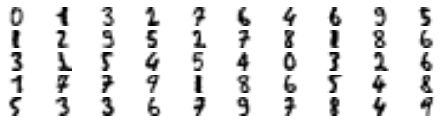

In [ ]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [ ]:
y_train[representative_digit_idx]

array([0, 1, 3, 2, 7, 6, 4, 6, 9, 5, 1, 2, 9, 5, 2, 7, 8, 1, 8, 6, 3, 1,
       5, 4, 5, 4, 0, 3, 2, 6, 1, 7, 7, 9, 1, 8, 6, 5, 4, 8, 5, 3, 3, 6,
       7, 9, 7, 8, 4, 9])

In [ ]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 2, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9133333333333333

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

### Propagate labels within the clusters
Up to this point we've used clustering to select a handful of representative samples that, once labeled, could represent the full data much better than random samples, thus improving classification results. 
We'll now go a step further and label the remaining unlabeled samples by propagating the labels of the cluster centroids:

1. Create a new label array for all the training samples by giving them the same label of their cluster centroid.
2. Train a logistic regression model on this new set of labeled samples. Could you improve its accuracy any further? It is probabily not the same as having a fully labeled dataset, but it is lileky better than using only 50 labeled samples!
3. Label propagation helps the most when the propagated labels are accurate. Since we have the true labels for this samples, check the accuracy of the propagated labels array. It being accurate explains the accuracy improvement observed just before.



Step 1: propagate the label of the representative image to all images in the cluster

In [ ]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
# loop throug each
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [ ]:
log_reg.score(X_test, y_test)

0.9244444444444444

In [ ]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [ ]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [ ]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [ ]:
log_reg.score(X_test, y_test)

0.9266666666666666

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 92.7% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [ ]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9592039800995025

## Exercise 4: k-means on Olivetti faces dataset
The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. 

1. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function, then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). 
Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.

2. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in the k-means tutorial). 

3. Visualize the clusters: do you see similar faces in each cluster?

In [ ]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

In [ ]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [ ]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [ ]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)



2. Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in the k-means tutorial). 


To speed things up, we'll reduce the data's dimensionality using PCA:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

In [ ]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


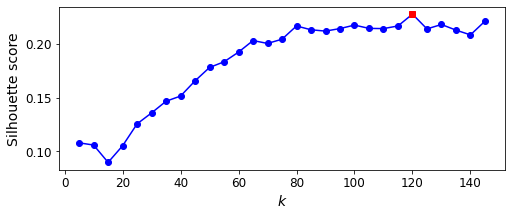

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [ ]:
best_k

120

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

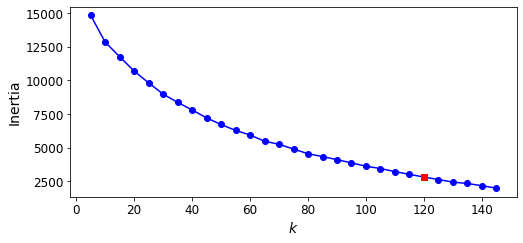

In [ ]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=120.

In [ ]:
best_model = kmeans_per_k[best_index]


3. Visualize the clusters: do you see similar faces in each cluster?

Cluster 0


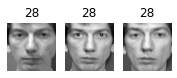

Cluster 1


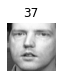

Cluster 2


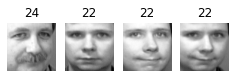

Cluster 3


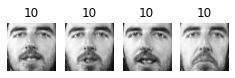

Cluster 4


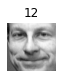

Cluster 5


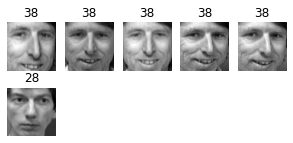

Cluster 6


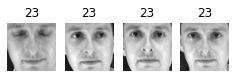

Cluster 7


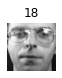

Cluster 8


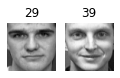

Cluster 9


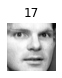

Cluster 10


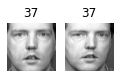

Cluster 11


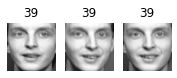

Cluster 12


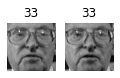

Cluster 13


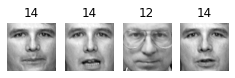

Cluster 14


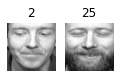

Cluster 15


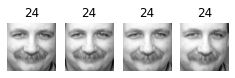

Cluster 16


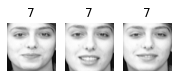

Cluster 17


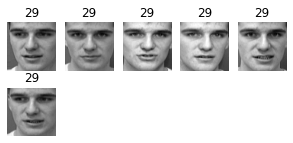

Cluster 18


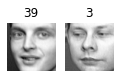

Cluster 19


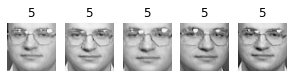

Cluster 20


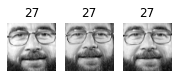

Cluster 21


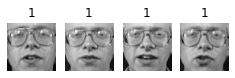

Cluster 22


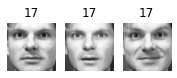

Cluster 23


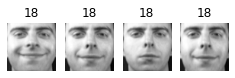

Cluster 24


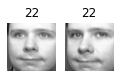

Cluster 25


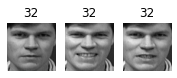

Cluster 26


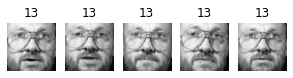

Cluster 27


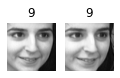

Cluster 28


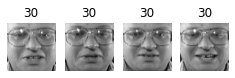

Cluster 29


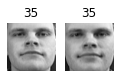

Cluster 30


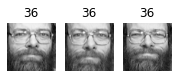

Cluster 31


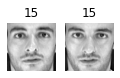

Cluster 32


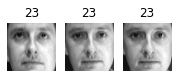

Cluster 33


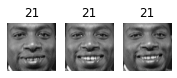

Cluster 34


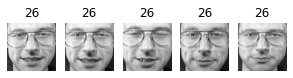

Cluster 35


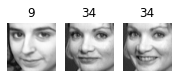

Cluster 36


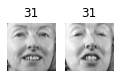

Cluster 37


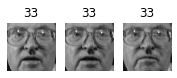

Cluster 38


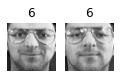

Cluster 39


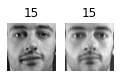

Cluster 40


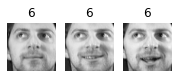

Cluster 41


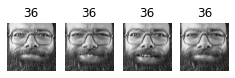

Cluster 42


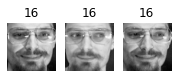

Cluster 43


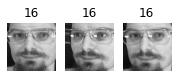

Cluster 44


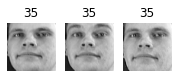

Cluster 45


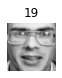

Cluster 46


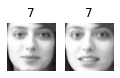

Cluster 47


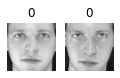

Cluster 48


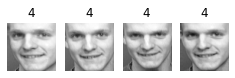

Cluster 49


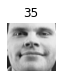

Cluster 50


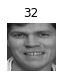

Cluster 51


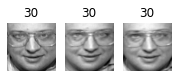

Cluster 52


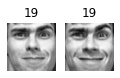

Cluster 53


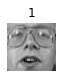

Cluster 54


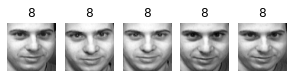

Cluster 55


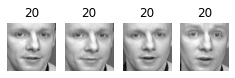

Cluster 56


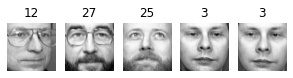

Cluster 57


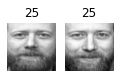

Cluster 58


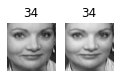

Cluster 59


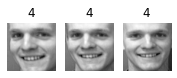

Cluster 60


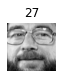

Cluster 61


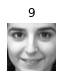

Cluster 62


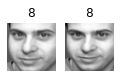

Cluster 63


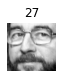

Cluster 64


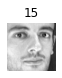

Cluster 65


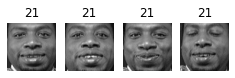

Cluster 66


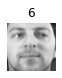

Cluster 67


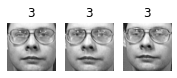

Cluster 68


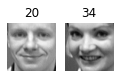

Cluster 69


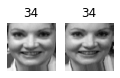

Cluster 70


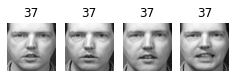

Cluster 71


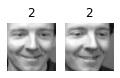

Cluster 72


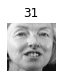

Cluster 73


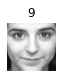

Cluster 74


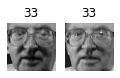

Cluster 75


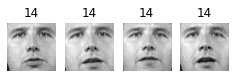

Cluster 76


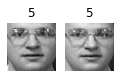

Cluster 77


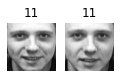

Cluster 78


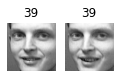

Cluster 79


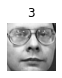

Cluster 80


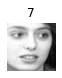

Cluster 81


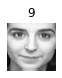

Cluster 82


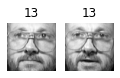

Cluster 83


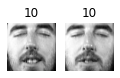

Cluster 84


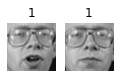

Cluster 85


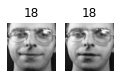

Cluster 86


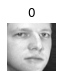

Cluster 87


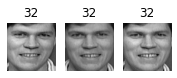

Cluster 88


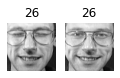

Cluster 89


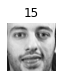

Cluster 90


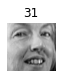

Cluster 91


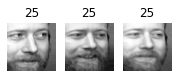

Cluster 92


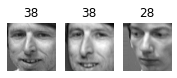

Cluster 93


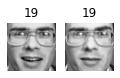

Cluster 94


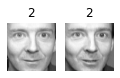

Cluster 95


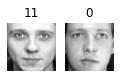

Cluster 96


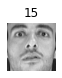

Cluster 97


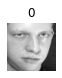

Cluster 98


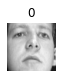

Cluster 99


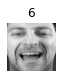

Cluster 100


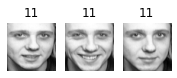

Cluster 101


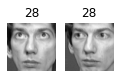

Cluster 102


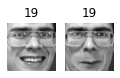

Cluster 103


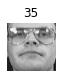

Cluster 104


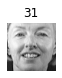

Cluster 105


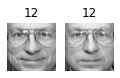

Cluster 106


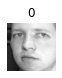

Cluster 107


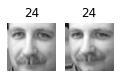

Cluster 108


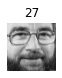

Cluster 109


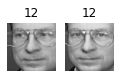

Cluster 110


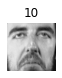

Cluster 111


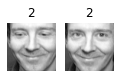

Cluster 112


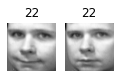

Cluster 113


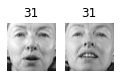

Cluster 114


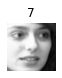

Cluster 115


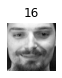

Cluster 116


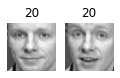

Cluster 117


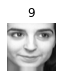

Cluster 118


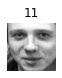

Cluster 119


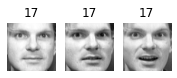

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## Exercise 5: GMM on Olivetti faces dataset

1. Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset’s 
dimensionality (e.g., use PCA, preserving 99% of the variance). 
2. Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method). 
3. Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

In [ ]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

2. Use the model to generate some new faces (using the sample() method), and visualize them (if you used PCA, you will need to use its inverse_transform() method). 


In [ ]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

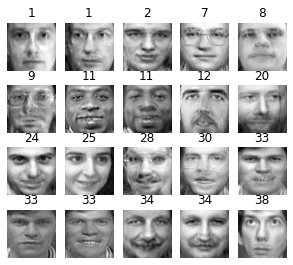

In [ ]:
plot_faces(gen_faces, y_gen_faces)

3. Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the score_samples() method for normal images and for anomalies).

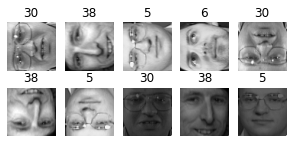

In [ ]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [ ]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [ ]:
gm.score_samples(X_bad_faces_pca)

array([-2.43643267e+07, -1.89785012e+07, -3.78112367e+07, -4.98187629e+07,
       -3.20479020e+07, -1.37531267e+07, -2.92373870e+07, -1.05489069e+08,
       -1.19575421e+08, -6.74256883e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [ ]:
gm.score_samples(X_train_pca[:10])

array([1163.02020926, 1134.03637965, 1156.32132746, 1170.67602789,
       1141.45404798, 1154.352051  , 1091.32894399, 1111.4114952 ,
       1096.43049058, 1132.98982659])

## Exercise 6: Mall customer segmentation
Download the following dataset about mall customers, then try to segment these customers into a few groups corresponding to typical spending profiles.

In [145]:
!wget "https://github.com/SteffiPeTaffy/machineLearningAZ/raw/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"

--2022-12-07 15:38:18--  https://github.com/SteffiPeTaffy/machineLearningAZ/raw/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv [following]
--2022-12-07 15:38:18--  https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githu


1. Check which features look most relevant to segmenting this customer base into groups. You can use the seaborn `pairplot` function to visualize all features plotted against each other.
2. Apply k-means clustering and hierarchical clustering to the features you selected in the previous step. 
Do both methods find similar groups? 
3. What are the main characteristics of the clusters found by each method? Try to visualize the clusters with respect to age, income and spending score.




To plot a dendrogram for hierarchical clustering, you will need to build a linkage matrix and then call scipy's `sp.cluster.hierarchy.dendrogram` function on it. Check the documentation for more details on how to customize your plot.

Here is a function that builds the linkage matrix given an `AgglomerativeClustering` model.

In [146]:
def create_linkage_matrix(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

Let's use Pandas to read the csv file into a `pd.DataFrame`:

In [147]:
data = pd.read_csv('Mall_Customers.csv')
data

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


We have 5 columns, though the first one is simply an identifier, not particularly useful for data analysis. Let's proceed by droping this column with IDs and plotting all features against each other. The gender column is categorical with only two values, the others are numerical. We'll have the numerical features be represented in the axis, and represent this categorical feature with colors (using the seaborn argument `hue` in the `pairplot` function):

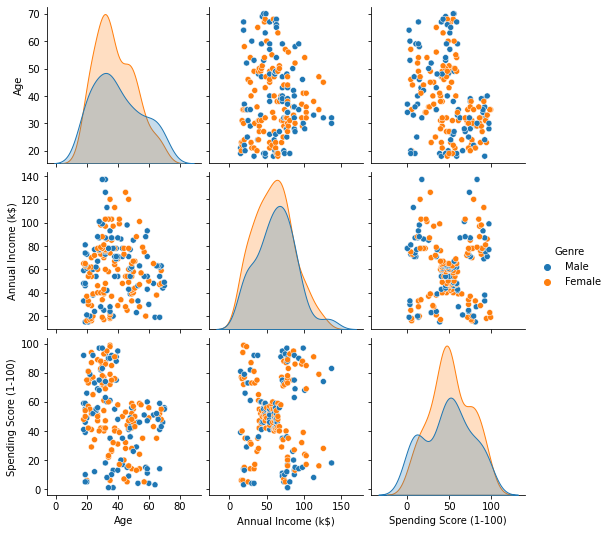

In [148]:
sns.pairplot(data.drop(columns=['CustomerID']), hue='Genre')

From the pairplot we can observe that gender is not a very discriminative feature, so that it is reasonable to ignore it when choosing our clustering features.

Here we'll build an X input matrix to train our clustering methods:

In [149]:
X = data.drop(columns=['CustomerID', 'Genre'])

### K-means clustering

In [150]:
from sklearn.cluster import KMeans
k_values = np.arange(2, 10)
kmeans_models = [KMeans(k, random_state=42).fit(X) for k in k_values]
kmeans_per_k = dict(zip(k_values, kmeans_models))

Text(0, 0.5, 'inertia')

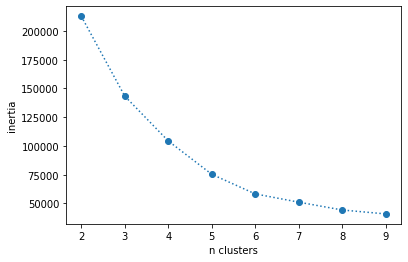

In [151]:
y = [m.inertia_ for m in kmeans_models]
plt.plot(k_values, y, 'o:')
plt.xlabel("n clusters")
plt.ylabel("inertia")

This elbow curve suggest a number of clusters between 4 and 7. Given that we have a small number of features, we can visualize how different K values segment our customer base to decide which version to use. 

Segmenting the customer base of a mall may lead to identifying client profiles more likely to spend at the mall thus helping to target marketing campaigns. In this scenario, using an overly large number of small clusters could be innefective in assisting this business decision. It is likely that using a lower number of clusters is enough to produce useful insights.

Based on the previous pair plot, we could identify visually the existence of at least 5 well defined groups in when plotting Spending score vs Anual income. We'll then start by analysing results for K=5.

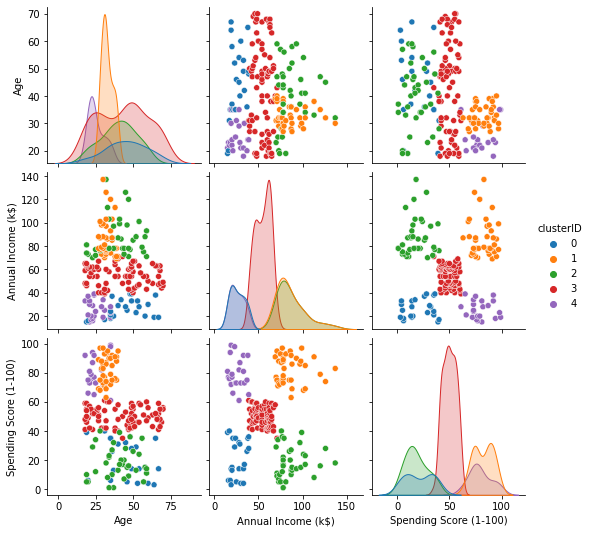

In [152]:
K = 5
df = data.drop(columns=['CustomerID'])
df['clusterID'] = kmeans_per_k[K].labels_
sns.pairplot(df, hue='clusterID', palette=sns.color_palette('tab10')[:K])

In [153]:
size_ratio = df.clusterID.value_counts(normalize='True')
size_ratio.name='Cluster size (in %)'
size_ratio *=100

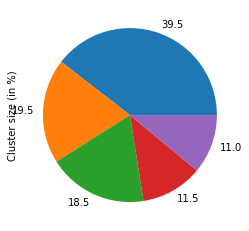

In [154]:
size_ratio.plot.pie(labels=size_ratio, colors=sns.color_palette('tab10')[:K])

Let's display a summary of each cluster:

In [155]:
df.groupby(by='clusterID').describe()

Age                                                        \
          count       mean        std   min    25%   50%    75%   max   
clusterID                                                               
0          23.0  45.217391  13.228607  19.0  35.50  46.0  53.50  67.0   
1          39.0  32.692308   3.728650  27.0  30.00  32.0  35.50  40.0   
2          37.0  40.324324  11.525465  19.0  34.00  41.0  47.00  59.0   
3          79.0  43.126582  16.446781  18.0  27.00  47.0  54.50  70.0   
4          22.0  25.272727   5.257030  18.0  21.25  23.5  29.75  35.0   

          Annual Income (k$)             ...                \
                       count       mean  ...    75%    max   
clusterID                                ...                 
0                       23.0  26.304348  ...  33.00   39.0   
1                       39.0  86.538462  ...  95.00  137.0   
2                       37.0  87.432432  ...  97.00  137.0   
3                       79.0  54.822785  ...  62.00   71.0   
4                       22.0  25.727273  ...  32.25   39.0   

          Spending Score (1-100)                                          \
                           count       mean        std   min   25%   50%   
clusterID                                                                  
0                           23.0  20.913043  13.017167   3.0   9.5  17.0   
1                           39.0  82.128205   9.364489  63.0  74.5  83.0   
2                           37.0  18.189189  10.715611   1.0  10.0  16.0   
3                           79.0  49.835443   6.276595  35.0  45.5  50.0   
4                           22.0  79.363636  10.504174  61.0  73.0  77.0   

                        
             75%   max  
clusterID               
0          33.50  40.0  
1          90.00  97.0  
2          26.00  40.0  
3          55.00  61.0  
4          85.75  99.0  

[5 rows x 24 columns]

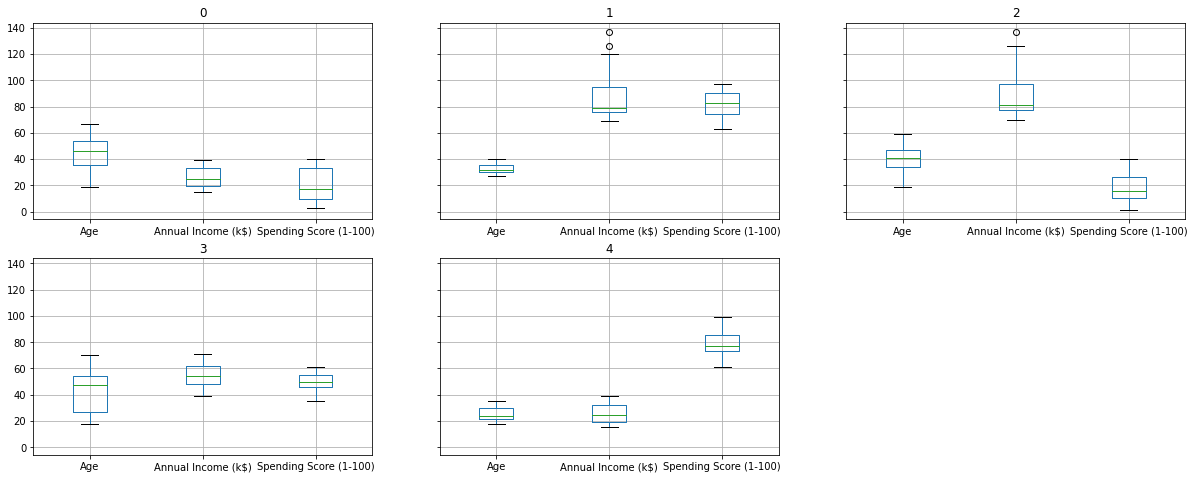

In [156]:
df.groupby(by='clusterID').boxplot(column=['Age','Annual Income (k$)','Spending Score (1-100)'], layout=(2,3), figsize=(20,8));

Based on these plots we can characterize 5 profiles:

- Average customer (cluster 3, red): Middle-class middle-spending level customers of all ages. This is the largest group (39.5%). 
- Big spenders (cluster 1, orange): Upper income class in their 30s with high spending score.
- Young spenders (cluster 4, purple): Lower income younger customers in their 20s with a high spending score.  
- Thrifty high-income customers (cluster 2, green): Upper income class with low spending score, slighthly older than the "Big spenders" group (34-47).
- Thrifty low-income customers (cluster 0, blue): Low spending low income class group spanning all ages, though mostly 35+.

### Hierarchical agglomerative clustering

Now let's apply agglomerative clustering to the same data to see if we find similar groups:

In [157]:
from sklearn.cluster import AgglomerativeClustering
hac = AgglomerativeClustering(affinity='euclidean', linkage='ward',
                              n_clusters=5, 
                              compute_distances=True)
hac.fit(X)

AgglomerativeClustering(compute_distances=True, n_clusters=5)

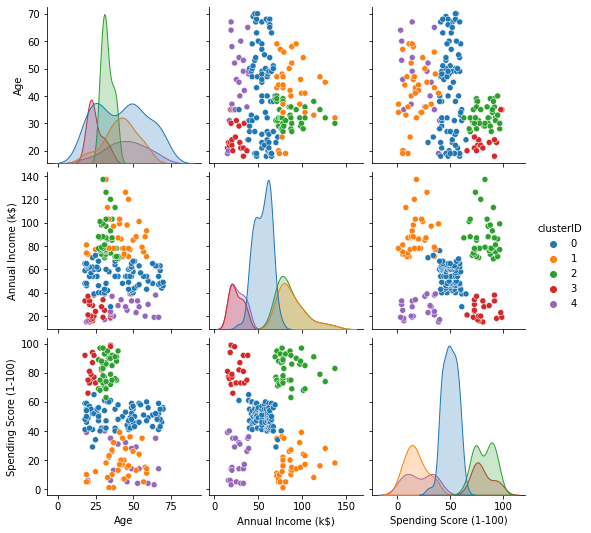

In [158]:
df2 = data.drop(columns=['CustomerID'])
df2['clusterID'] = hac.labels_
sns.pairplot(df2, hue='clusterID', palette=sns.color_palette('tab10')[:K])

The groups look similar to what we get with K-means. Let's replot the previous pairplot to ease visual comparison:

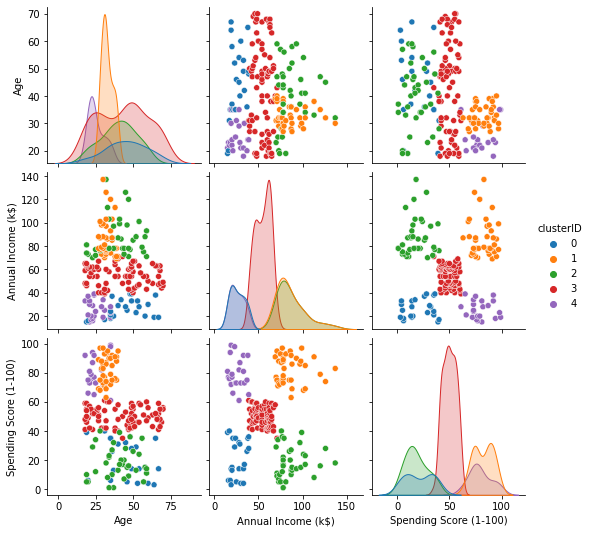

In [159]:
sns.pairplot(df, hue='clusterID', palette=sns.color_palette('tab10')[:K])

From the distributions plotted for each cluster, we can note some multimodal distributions (eg cluster 1 w.r.t. spending score). This indicates these groups could be further split in sub-groups.

With agglomerative clustering, we can look at the dendrogram to hiarachically visualize these sub groups.

In [162]:
linkage_mat = create_linkage_matrix(hac)
linkage_mat.shape

(199, 4)

Text(0, 0.5, 'Euclidean distance')

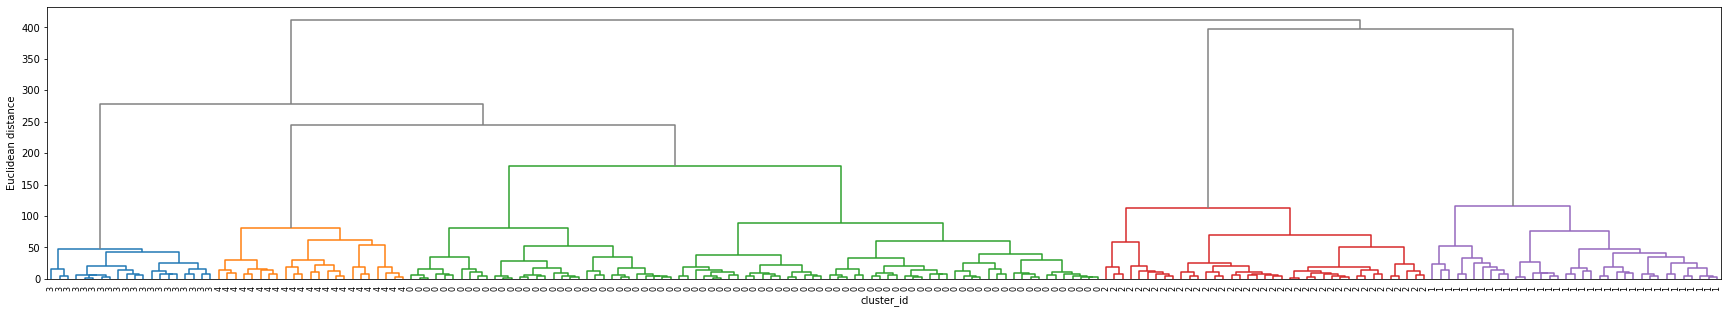

In [169]:
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette


color_list = [f'C{k}' for k in [3,4,0,2,1]]
set_link_color_palette(color_list)

# we can set the distance threshold at which we mean to cut the dendrogram
# I'm using half of the maximum distance as threshold
threshold = hac.distances_.max()*0.5
# I set the dendrogram to color links according to the threshold
info = dendrogram(linkage_mat, 
                  color_threshold=threshold,
                  labels=hac.labels_,
                  above_threshold_color='gray',
                  )
plt.gcf().set_size_inches(30,5)
plt.xticks(fontsize=8)
plt.xlabel('cluster_id')
plt.ylabel('Euclidean distance')

Zooming in the picture we can see through the labels that the clusters are presented in the following order: 3, 4, 0, 2, 1. That is why `color_list` is set accordingly.

The dendrogram suggests a possible splitting of the largest cluster (here with id=0) in two parts.

Let's select only the samples in this subset and apply hierarchical clustering to divide it in 2 groups:

In [ ]:
df_large_cluster = df2[df2['clusterID']==0].copy()
X_large_cluster = df_large_cluster.drop(columns=['Genre', 'clusterID'])

In [ ]:
hac_large_cluster = AgglomerativeClustering(
    affinity='euclidean', linkage='ward',
    n_clusters=2).fit(X_large_cluster)

In [ ]:
df_large_cluster.loc[:, 'clusterID'] = hac_large_cluster.labels_

In [ ]:
df_large_cluster

,Genre,Age,Annual Income (k$),Spending Score (1-100),clusterID
27,Male,35,28,61,1
43,Female,31,39,61,1
45,Female,24,39,65,1
46,Female,50,40,55,0
47,Female,27,40,47,1
...,...,...,...,...,...
121,Female,38,67,40,0
122,Female,40,69,58,0
124,Female,23,70,29,1
132,Female,25,72,34,1


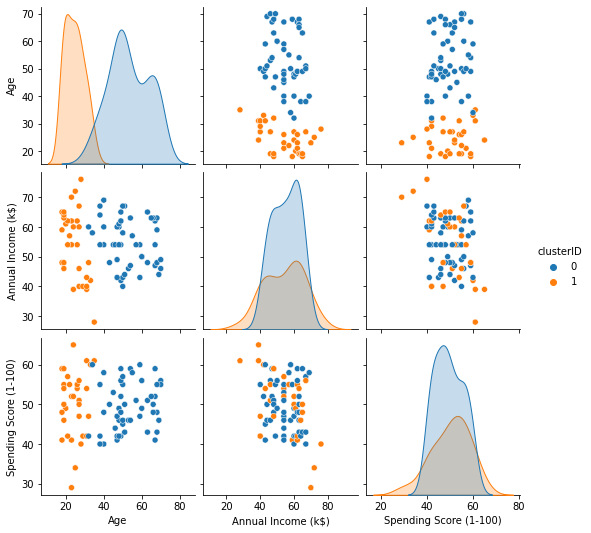

In [ ]:
sns.pairplot(df_large_cluster, hue='clusterID', palette=sns.color_palette('tab10')[:2])

We get two subgroups having age as the main discriminant factor. There is no observable difference in terms of spending score or income.

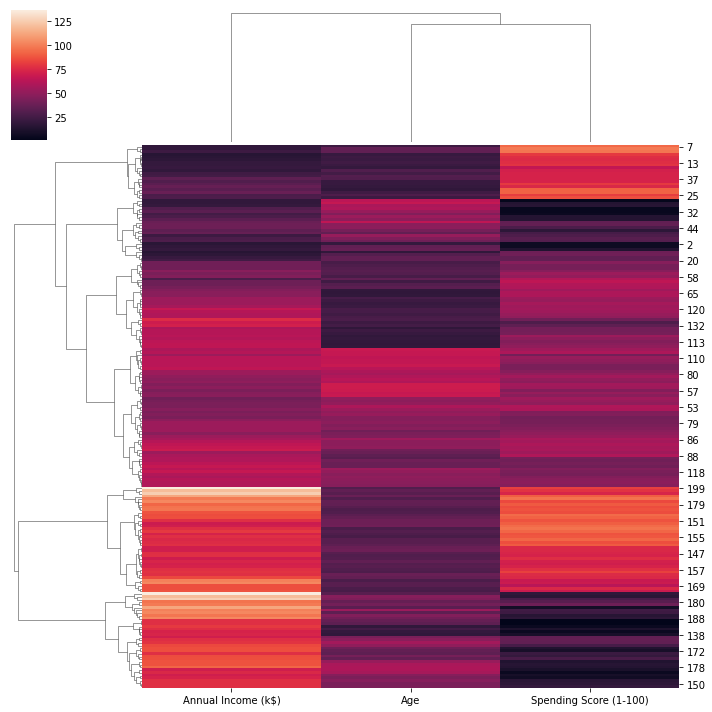

In [177]:
sns.clustermap(df.drop(columns=['Genre', 'clusterID']),
               method='ward')